Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

**Introduction**

L’exploitation d’un avion s’accompagne de conditions de vol très variables et difficiles à prédire, ce qui rend complexe l’estimation précise des chargements structuraux rencontrés en situation réelle. Bien que des informations telles que les déformations et les contraintes soient essentielles pour optimiser la maintenance et améliorer les modèles de dimensionnement, ces grandeurs ne sont généralement pas mesurées directement sur les aéronefs commerciaux. L’installation de capteurs dédiés entraînerait en effet une augmentation significative des coûts, de la masse, de la complexité d’intégration et des exigences de certification.

Le Mini-Challenge propose ainsi de développer un capteur virtuel basé sur des méthodes d’apprentissage automatique, capable d’estimer l’état de contrainte structurelle en différents points de l’avion à partir des seuls paramètres déjà enregistrés par l’instrumentation de bord. L’objectif est de prédire des grandeurs non mesurées physiquement, mais inférées à partir de variables de vol telles que l’attitude, les vitesses, les accélérations, les ordres de commande et les conditions de vent.

Pour cela, un ensemble de données réelles provenant de 44 vols d’essai est mis à disposition. Ce jeu de données comprend :

39 paramètres issus de l’instrumentation de bord, représentant l’état de vol, les efforts aérodynamiques et les actions de contrôle ;

15 jauges d’extensométrie (en micro-déformations, με) positionnées en différents points structuraux de l’appareil, permettant de mesurer directement les contraintes locales.

En résumé, ce projet vise à démontrer la capacité d’un modèle d’apprentissage supervisé à reproduire les contraintes structurelles réelles à partir de données opérationnelles courantes, ouvrant la voie à des stratégies de maintenance plus prédictives, moins coûteuses et mieux informées, dans la continuité des travaux précédents sur les capteurs virtuels pour le suivi de santé structurale.

Pour cette projet, on va se baser dans la teorie de Machine Learning, en se basent dans l'image ci dessous :

In [ ]:
# from IPython.display import Image
# (Image(filename="Workflow_DL.png"))

**Management des données**

Le liste de variable avec les description et sont format qui existe dans les données collectées pendant les vols sont en dessous :

In [ ]:
# (Image(filename="table.png"))


In [1]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Management des données** - Acquisition des données

In [ ]:
# Creating the dataframes data[Tol_1], ..., data[Tol_48]
# data = {}
# for file in glob.glob('./Data_AirLoadBench/TOL_*.csv'):
#     base = os.path.basename(file)
#     name = base.replace('.csv', '')
#     data[name]  = pd.read_csv(file)

In [ ]:
# Displaying the colums existing in each dataframe
data['TOL_1'].columns

Displayng the dataframes

In [ ]:
data['TOL_1']

In [ ]:
data['TOL_1'].columns

**Management des données** - Exploration des Données

In [ ]:
# # ============================================================
# # 1) Sélection du DataFrame principal
# # ============================================================
# df = data['TOL_1']   # Votre DataFrame d'origine


# # ============================================================
# # 2) Listes des colonnes (Y = variables de vol, X = strains)
# # ============================================================
# y_cols = [
#     'Relative_Time', 'Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA',
#     'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT',
#     'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1',
#     'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos',
#     'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2',
#     'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos',
#     'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos',
#     'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos'
# ]

# x_cols = [
#     'Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6',
#     'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12',
#     'Strain13', 'Strain14', 'Strain15'
# ]


# # ============================================================
# # 3) Conversion des colonnes en valeurs numériques
# #    (évite des erreurs si certaines colonnes contiennent du texte)
# # ============================================================
# df_numeric = df.copy()

# for col in y_cols + x_cols:
#     if col in df_numeric.columns:  # sécurité si une colonne manque
#         df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')


# # ============================================================
# # 4) Génération des graphiques de dispersion (scatter)
# #    Pour chaque strain, une figure contenant plusieurs sous-graphiques
# #    Axe X = strain, Axe Y = variable de vol
# # ============================================================
# for strain in x_cols:

#     if strain not in df_numeric.columns:
#         print(f"La colonne {strain} n'est pas présente dans le DataFrame, ignorée.")
#         continue

#     # grille 7x6 de sous-graphiques (42 cases, nous avons 41 variables Y)
#     fig, axes = plt.subplots(
#         nrows=7, 
#         ncols=6, 
#         figsize=(18, 20),
#         sharex=False, 
#         sharey=False
#     )
#     axes = axes.ravel()  # transforme la grille en liste linéaire

#     # Pour chaque variable Y, créer un scatter plot
#     for i, y in enumerate(y_cols):

#         if y not in df_numeric.columns:
#             print(f"La colonne {y} n'est pas présente dans le DataFrame, ignorée.")
#             continue

#         ax = axes[i]

#         ax.scatter(
#             df_numeric[strain],
#             df_numeric[y],
#             s=5,
#             alpha=0.5
#         )
#         ax.set_xlabel(strain, fontsize=8)
#         ax.set_ylabel(y, fontsize=8)
#         ax.tick_params(labelsize=8)

#     # Suppression des sous-graphiques inutilisés
#     for j in range(len(y_cols), len(axes)):
#         fig.delaxes(axes[j])

#     # Titre global de la figure
#     fig.suptitle(
#         f'Relation entre {strain} et les variables de vol (Données : TOL_1)',
#         fontsize=16
#     )

#     plt.tight_layout()
#     plt.savefig(f"scatter_{strain}.png", dpi=300)
#     plt.show()


# # ============================================================
# # 5) Heatmap des corrélations (optionnel mais très utile)
# #    Visualisation de la corrélation entre toutes les Y et toutes les Strains
# # ============================================================
# cols_present = [c for c in (y_cols + x_cols) if c in df_numeric.columns]

# # matrice de corrélation
# corr = df_numeric[cols_present].corr()

# # sous-matrice : lignes = Y, colonnes = Strains
# corr_sub = corr.loc[
#     [c for c in y_cols if c in corr.index],
#     [c for c in x_cols if c in corr.columns]
# ]

# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     corr_sub,
#     annot=True,
#     fmt=".2f",
#     cmap='coolwarm',
#     center=0,
#     annot_kws={"size": 8} 

# )
# plt.xlabel('Strains')
# plt.ylabel('Variables de vol')
# plt.title('Corrélations entre les variables de vol et les strains (TOL_1)')
# plt.savefig("heatmap_correlations_TOL1.png", dpi=300)
# plt.tight_layout()
# plt.show()



Ploting grqphs for correlation

In [ ]:
base_path = "./"

for i in range(1, 16):
    filename = f"{base_path}scatter_Strain{i}.png"
    
    img = mpimg.imread(filename)
    plt.figure(figsize=(20, 12))   # <<< ALTERADO PARA FICAR BEM GRANDE
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"scatter_Strain{i}.png", fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
img = mpimg.imread("heatmap_correlations_TOL1.png")

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Heatmap des corrélations (TOL_1)")
plt.show()

**Management des données** - Préparation des Données

In [ ]:
dfs = []  # lista para guardar todos os dataframes

for name, df in data.items():
    df_temp = df.copy()
    df_temp["Tol_ID"] = name     # adiciona coluna identificando o TOL
    dfs.append(df_temp)

# junta tudo em um dataframe só
df = pd.concat(dfs, ignore_index=True)

df.to_csv('df.csv', index=False)

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
df.head(10)

,Nz,Nx,Roll_Angle,Pitch_Angle,True_AOA,True_Sideslip,FPA,True_Heading,CAS,TAS,...,Strain7,Strain8,Strain9,Strain10,Strain11,Strain12,Strain13,Strain14,Strain15,Tol_ID
0,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TOL_1
1,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,-0.601572,-0.884219,-0.463841,0.161175,-0.000325,-0.143096,0.403351,0.006286,0.175358,TOL_1
2,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.824664,0.0,0.0,...,-0.310433,-1.410038,-1.853289,0.646155,-0.000651,-0.571435,0.818918,0.012573,0.350715,TOL_1
3,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.424748,-1.414549,-1.854326,0.174219,-0.000976,-1.013577,1.216162,-1.045466,-0.521183,TOL_1
4,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.572497,-2.114138,2.512348,0.644700,0.579980,-0.572384,1.613406,0.691031,0.003260,TOL_1
5,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,1.025526,-1.238943,3.135614,0.486903,0.579654,-0.572858,1.613664,0.691860,0.004075,TOL_1
6,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.289817,-0.374608,1.565383,0.319440,0.579329,-0.577933,1.595600,0.004970,0.004890,TOL_1
7,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826069,0.0,0.0,...,0.879296,0.489727,-0.923224,0.166476,0.572297,-0.576107,-0.181416,-1.214082,-0.517923,TOL_1
8,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826269,0.0,0.0,...,-0.020616,-1.437107,-0.606083,0.013512,0.578679,-0.574281,0.820468,0.006627,0.006520,TOL_1
9,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825868,0.0,0.0,...,0.434725,0.828243,-0.771030,0.319675,0.578353,-0.577056,0.613072,0.184843,0.181878,TOL_1


In [5]:
# Targets = deformações (saídas do modelo)
target_cols = [f"Strain{i}" for i in range(1, 16)]

# Features = todas as colunas menos Strains e Flight_ID
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [6]:
# Remove linhas com NaN nas colunas importantes
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols].values      # entradas
y = df_clean[target_cols].values      # saídas (strains)
Tol_ids = df_clean["Tol_ID"].values  # de qual TOL é cada linha

In [7]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [19]:
X_val_scaled[5]

array([-0.3708933 , -0.11542678,  0.07510239,  0.19188693, -0.43604229,
       -0.0910197 , -0.77594447, -0.73579405,  0.61100837,  0.65105954,
        0.64025708, -0.21392578,  0.64963979, -0.01777034, -0.39822823,
       -0.0335681 ,  0.37542293,  0.22062762, -0.13445874, -0.14267856,
        0.12893294,  0.08872095,  0.43616133,  0.37202951,  0.4198703 ,
        0.38490178, -0.65335558, -0.65342495, -0.65393171,  0.51182382,
       -0.53519562, -0.68243806, -0.68120979,  0.05854381, -0.0946751 ,
       -0.06025482,  0.6902174 , -0.52157772,  0.03070494])

In [9]:
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StrainDataset(X_train_scaled, y_train_scaled)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [10]:
n_features = X_train_scaled.shape[1]
n_outputs  = y_train_scaled.shape[1]   # 15 strains

class StrainMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StrainMLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

n_epochs = 30

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss   = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

100%|██████████| 19303/19303 [01:39<00:00, 194.83it/s]


Epoch 001 | Train loss: 0.130879 | Val loss: 0.095176


100%|██████████| 19303/19303 [01:45<00:00, 182.86it/s]


Epoch 002 | Train loss: 0.081845 | Val loss: 0.072663


100%|██████████| 19303/19303 [01:50<00:00, 174.74it/s]


Epoch 003 | Train loss: 0.068274 | Val loss: 0.066112


100%|██████████| 19303/19303 [01:51<00:00, 173.68it/s]


Epoch 004 | Train loss: 0.061362 | Val loss: 0.059648


100%|██████████| 19303/19303 [01:50<00:00, 175.08it/s]


Epoch 005 | Train loss: 0.056990 | Val loss: 0.058160


100%|██████████| 19303/19303 [01:51<00:00, 172.67it/s]


Epoch 006 | Train loss: 0.053869 | Val loss: 0.052475


100%|██████████| 19303/19303 [01:50<00:00, 173.91it/s]


Epoch 007 | Train loss: 0.051437 | Val loss: 0.051189


100%|██████████| 19303/19303 [01:50<00:00, 174.09it/s]


Epoch 008 | Train loss: 0.049696 | Val loss: 0.049457


100%|██████████| 19303/19303 [01:51<00:00, 173.69it/s]


Epoch 009 | Train loss: 0.048221 | Val loss: 0.048602


100%|██████████| 19303/19303 [01:51<00:00, 173.88it/s]


Epoch 010 | Train loss: 0.047089 | Val loss: 0.048915


100%|██████████| 19303/19303 [01:50<00:00, 174.53it/s]


Epoch 011 | Train loss: 0.046087 | Val loss: 0.045763


100%|██████████| 19303/19303 [01:50<00:00, 174.62it/s]


Epoch 012 | Train loss: 0.045213 | Val loss: 0.045519


100%|██████████| 19303/19303 [01:51<00:00, 173.15it/s]


Epoch 013 | Train loss: 0.044468 | Val loss: 0.044535


100%|██████████| 19303/19303 [01:51<00:00, 173.41it/s]


Epoch 014 | Train loss: 0.043752 | Val loss: 0.043530


100%|██████████| 19303/19303 [01:51<00:00, 173.57it/s]


Epoch 015 | Train loss: 0.043179 | Val loss: 0.045499


100%|██████████| 19303/19303 [01:51<00:00, 173.42it/s]


Epoch 016 | Train loss: 0.042658 | Val loss: 0.042052


100%|██████████| 19303/19303 [01:51<00:00, 173.78it/s]


Epoch 017 | Train loss: 0.042154 | Val loss: 0.041778


100%|██████████| 19303/19303 [01:51<00:00, 173.76it/s]


Epoch 018 | Train loss: 0.041678 | Val loss: 0.042065


100%|██████████| 19303/19303 [01:50<00:00, 174.85it/s]


Epoch 019 | Train loss: 0.041304 | Val loss: 0.040661


100%|██████████| 19303/19303 [01:51<00:00, 173.78it/s]


Epoch 020 | Train loss: 0.040977 | Val loss: 0.041112


100%|██████████| 19303/19303 [01:51<00:00, 173.60it/s]


Epoch 021 | Train loss: 0.040656 | Val loss: 0.041284


100%|██████████| 19303/19303 [01:51<00:00, 173.77it/s]


Epoch 022 | Train loss: 0.040339 | Val loss: 0.041212


100%|██████████| 19303/19303 [01:51<00:00, 173.69it/s]


Epoch 023 | Train loss: 0.040041 | Val loss: 0.041262


100%|██████████| 19303/19303 [01:51<00:00, 173.52it/s]


Epoch 024 | Train loss: 0.039732 | Val loss: 0.040581


100%|██████████| 19303/19303 [01:50<00:00, 174.32it/s]


Epoch 025 | Train loss: 0.039488 | Val loss: 0.040818


100%|██████████| 19303/19303 [01:51<00:00, 173.85it/s]


Epoch 026 | Train loss: 0.039266 | Val loss: 0.039111


100%|██████████| 19303/19303 [01:50<00:00, 175.26it/s]


Epoch 027 | Train loss: 0.039055 | Val loss: 0.040365


100%|██████████| 19303/19303 [01:51<00:00, 173.24it/s]


Epoch 028 | Train loss: 0.038822 | Val loss: 0.039888


100%|██████████| 19303/19303 [01:51<00:00, 173.87it/s]


Epoch 029 | Train loss: 0.038618 | Val loss: 0.038800


100%|██████████| 19303/19303 [01:50<00:00, 175.02it/s]


Epoch 030 | Train loss: 0.038433 | Val loss: 0.038194


In [68]:
# train_losses = [0.130879,    0.081845,    0.068274,    0.061362,    0.056990,    0.053869,    0.051437,    0.049696,    0.048221,    0.047089,
#     0.046087,    0.045213,    0.044468,    0.043752,    0.043179,    0.042658,    0.042154,    0.041678,    0.041304,    0.040977,    0.040656,
#     0.040339,    0.040041,    0.039732,    0.039488,    0.039266,    0.039055,    0.038822,    0.038618,    0.038433]

# val_losses = [0.095176,    0.072663,    0.066112,    0.059648,    0.058160,   0.052475,    0.051189,    0.049457,    0.048602,    0.048915,
#     0.045763,    0.045519,    0.044535,    0.043530,    0.045499,    0.042052,    0.041778,    0.042065,    0.040661,    0.041112,    0.041284,
#     0.041212,    0.041262,    0.040581,    0.040818,    0.039111,    0.040365,    0.039888,    0.038800,    0.038194]

# plt.figure(figsize=(10,6))

# epochs = range(1, len(train_losses) + 1)

# plt.plot(epochs, train_losses, label="Train Loss", marker='o')
# plt.plot(epochs, val_losses,   label="Validation Loss", marker='s')

# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.title("Train vs Validation Loss")
# plt.grid(True)
# plt.legend()
# plt.savefig('Train_vs_Validation_Loss.png', dpi=300)
# plt.tight_layout()
# plt.show()


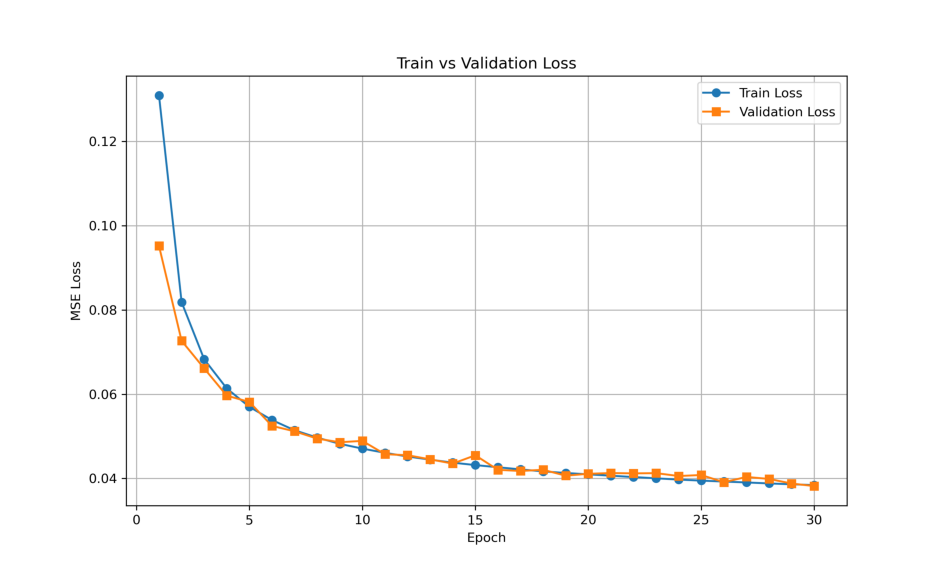

In [67]:
img = mpimg.imread("Train_vs_Validation_Loss.png")

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

lire les images de le training up side

In [ ]:
# model.eval()
# with torch.no_grad():
#     X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
#     y_pred_scaled = model(X_test_t).cpu().numpy()

# # # voltar para escala original das strains
# # y_test_real = scaler_y.inverse_transform(y_test)
# # y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

# y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
# y_test_real = scaler_y.inverse_transform(y_test_scaled)

# # métricas globais
# mae_global  = mean_absolute_error(y_test_real, y_pred_real)
# rmse_global = mean_squared_error(y_test_real, y_pred_real, squared=False)
# r2_global   = r2_score(y_test_real, y_pred_real)

# print("Overall metrics in the test set:")
# print(f"MAE  : {mae_global:.4f}")
# print(f"RMSE : {rmse_global:.4f}")
# print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 20.1988
RMSE : 31.1122
R²   : 0.9617


In [ ]:
# metrics_per_flight = {}
# unique_flights = np.unique(ids_test)

# for flight in unique_flights:
#     mask = (ids_test == flight)
#     y_true_f = y_test_real[mask]
#     y_pred_f = y_pred_real[mask]

#     mae  = mean_absolute_error(y_true_f, y_pred_f)
#     rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
#     r2   = r2_score(y_true_f, y_pred_f)

#     metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# for flight, m in metrics_per_flight.items():
#     print(f"{flight}: MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, R²={m['R2']:.4f}")

# mae_mean  = np.mean([m["MAE"]  for m in metrics_per_flight.values()])
# rmse_mean = np.mean([m["RMSE"] for m in metrics_per_flight.values()])
# r2_mean   = np.mean([m["R2"]   for m in metrics_per_flight.values()])

# print("\nAverage metrics across all TOLs (test):")
# print(f"MAE médio  : {mae_mean:.4f}")
# print(f"RMSE médio : {rmse_mean:.4f}")
# print(f"R² médio   : {r2_mean:.4f}")

TOL_1: MAE=17.5529, RMSE=25.8055, R²=0.9657
TOL_10: MAE=18.0899, RMSE=26.2752, R²=0.9397
TOL_11: MAE=18.8727, RMSE=29.8581, R²=0.9316
TOL_12: MAE=23.3357, RMSE=35.1869, R²=0.9332
TOL_13: MAE=19.3061, RMSE=26.4849, R²=0.9527
TOL_14: MAE=23.4041, RMSE=35.3518, R²=0.9449
TOL_15: MAE=25.6534, RMSE=37.8230, R²=0.9449
TOL_17: MAE=19.8521, RMSE=28.0189, R²=0.9552
TOL_18: MAE=25.4260, RMSE=40.4224, R²=0.9229
TOL_19: MAE=20.1272, RMSE=32.3409, R²=0.9321
TOL_2: MAE=16.0648, RMSE=24.1934, R²=0.9465
TOL_20: MAE=24.1636, RMSE=35.8319, R²=0.9295
TOL_21: MAE=15.9664, RMSE=23.9632, R²=0.9683
TOL_22: MAE=14.1701, RMSE=19.5308, R²=0.9057
TOL_23: MAE=17.1664, RMSE=27.2326, R²=0.9350
TOL_24: MAE=16.6983, RMSE=24.0797, R²=0.9437
TOL_25: MAE=17.5702, RMSE=25.5127, R²=0.9638
TOL_26: MAE=22.4661, RMSE=36.7640, R²=0.9546
TOL_27: MAE=19.8878, RMSE=29.0181, R²=0.9072
TOL_28: MAE=22.6312, RMSE=35.0161, R²=0.9210
TOL_29: MAE=21.1567, RMSE=31.3139, R²=0.9403
TOL_3: MAE=14.4300, RMSE=20.5138, R²=0.9678
TOL_30: MAE=1

In [ ]:
# df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

# # adicionar as métricas globais
# df_global = pd.DataFrame({
#     "MAE":  [mae_global],
#     "RMSE": [rmse_global],
#     "R2":   [r2_global]
# }, index=["GLOBAL"])

# # concatenar tudo
# df_results = pd.concat([df_flights, df_global])



In [ ]:
# df_results.to_csv('df_results_all.csv')

In [63]:
df_results = pd.read_csv('df_results_all.csv')
df_results


,Unnamed: 0,MAE,RMSE,R2
0,TOL_1,17.552930,25.805530,0.965695
1,TOL_10,18.089918,26.275248,0.939663
2,TOL_11,18.872680,29.858081,0.931578
3,TOL_12,23.335688,35.186905,0.933199
4,TOL_13,19.306073,26.484897,0.952701
5,TOL_14,23.404106,35.351755,0.944909
6,TOL_15,25.653372,37.822956,0.944918
7,TOL_17,19.852090,28.018926,0.955206
8,TOL_18,25.425999,40.422416,0.922942
9,TOL_19,20.127155,32.340869,0.932146
